## En esta parte agrego delta scutis que salieron hace muy poco! 

In [195]:
import pandas as pd

In [196]:
ident = pd.read_csv("ident.dat",delim_whitespace=True,names=["ID","Subtype","RA","DEC","field","other","a","b","c"])

In [197]:
star_info = [
    "ID",
    "Intensity mean I-band magnitude",
    "Intensity mean V-band magnitude",
    "per",
    "Uncertainty of primary period",
    "Time of maximum brightness (HJD-2450000)",
    "I-band amplitude (maximum-minimum)",
    "Fourier coefficient R_21",
    "Fourier coefficient phi_21",
    "Fourier coefficient R_31",
    "Fourier coefficient phi_31",
    "Secondary period (if available)",
    "Uncertainty of secondary period",
    "aTime of maximum brightness (HJD-2450000)",
    "aI-band amplitude (maximum-minimum)",
    "Fourier coefficient R_21 (2)",
    "Fourier coefficient phi_21 (2)",
    "Fourier coefficient R_31 (2)",
    "Fourier coefficient phi_31 (2)",
    "Tertiary period (if available)",
    "Uncertainty of tertiary period",
    "Time of maximum brightness (HJD-2450000) (3)",
    "I-band amplitude (maximum-minimum) (2)",
    "Fourier coefficient R_21 (3)",
    "Fourier coefficient phi_21 (3)",
    "Fourier coefficient R_31 (3)",
    "Fourier coefficient phi_31 (3)"
]


In [198]:
dsct = pd.read_csv("dsct.dat",delim_whitespace=True,names=star_info)

In [199]:
ident["types"] = "dsct"
ident["database"] = 4
ident["field"] = "smc"

In [200]:
dsct = dsct[["ID","per"]].merge(ident[["ID","Subtype","RA","DEC","types","database","field"]],how="inner",on="ID")

In [212]:
catalog = pd.read_csv("catalogos/0_catalog.csv")

In [207]:
catalog = pd.concat([catalog,dsct])

In [159]:
catalog.to_csv("catalogos/0_catalog.csv",index=False)

In [829]:
ray.shutdown()

In [830]:
ray.init()

2023-07-20 16:30:31,599	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.8.13
Ray version:,2.1.0


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


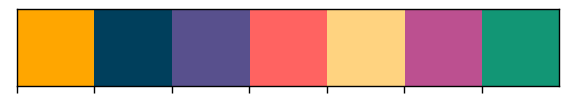

In [15]:
# Importaciones de bibliotecas estándar
# Importaciones de bibliotecas de sistema
import os
import gc
import time
import shutil

# Importaciones de bibliotecas de terceros
import wget
import scipy.signal
import h5py
import psutil
import ray

# Importaciones de TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras import backend as K 

# Importaciones de sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.utils import class_weight

# Importaciones de pandas
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Importaciones de matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.core.pylabtools import figsize, getfigs
%matplotlib inline

# Importaciones de seaborn
import seaborn as sns
gyr = ["#ffa600",
        '#003f5c',
       "#58508d",
       "#ff6361",
       "#ffd380",
       "#bc5090",
       "#129675"
      ]
palet = sns.palplot(sns.color_palette(gyr))
sns.set_context("paper")

# Importaciones de plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importaciones de numpy
import numpy as np

# Importaciones de astropy
from astropy.io import fits
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
import astropy.units as u

# Importaciones para el equilibrio de los datos
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

# Obtén el número de CPUs
num_cpus = psutil.cpu_count(logical=False)


class BalancedDataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras Sequence based data generator. 
       Suitable for building data generator for training and prediction.
    """
    def __init__(self, x, y, batch_size=64):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y)
        self.class_indices = [np.where(y == i)[0] for i in self.classes]
        self.length = min([len(i) for i in self.class_indices]) // self.batch_size * len(self.classes)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        for class_index in self.class_indices:
            i = idx % (len(class_index) // self.batch_size)
            batch_x.append(self.x[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
            batch_y.append(self.y[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
        return np.concatenate(batch_x), np.concatenate(batch_y)

    def on_epoch_end(self):
        for class_index in self.class_indices:
            np.random.shuffle(class_index)


# Funciones
def descarga_wget(database,ID,path_3,path_4):
    _,field,types,_ = ID.lower().split("-")
    try :
        if types=="ell":
            types="ecl"
        if database==4:
            if ((field =="blg") |(field =="gd"))&((types =="ecl")|(types =="lpv")|(types =="dsct")):
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot_ogle4/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
            else:
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
                
        if database==3:
            url = "http://ftp.astrouw.edu.pl/ogle/ogle3/OIII-CVS/" +field+"/"+types+"/phot/I/"+ ID +".dat"
            wget.download(url,path_3)
            return 1
    except:
        return 0
            
@ray.remote
def review_open_data(nomb,path_datos,database):
        path= path_datos[database]
        try :
            df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
            df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
            obs_eliminadas = len(df) - len(df_sigma)
            amplitud = df_sigma["mag"].max() - df_sigma["mag"].min()
            mag_mean = df_sigma["mag"].mean()
            mag_std = df_sigma["mag"].std()
            err_mean = df_sigma["err"].mean()
            err_std = df_sigma["err"].std()
            obs_final = len(df_sigma)
            obs_inicial = len(df)
            return 1,nomb,database,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial
        except:
            return 0,nomb,database,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

        
def ra_dec_to_degrees(ra_str, dec_str):
    # Convertir las coordenadas RA y DEC en objetos SkyCoord
    coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))

    # Obtener las coordenadas en grados
    ra_deg = coord.ra.degree
    dec_deg = coord.dec.degree

    return ra_deg, dec_deg

def fase_datos(path_datos,database,nomb,per_vsx):
    path= path_datos[database]
    df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
    df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
    if len(df_sigma)>2000:
        df_sigma = df_sigma.sample(2000,random_state=42).reset_index(drop=True)
    fase_vsx = np.mod(df_sigma.jd, per_vsx) / per_vsx
    mag_vsx,t_vsx,err_vsx =df_sigma.mag,df_sigma.jd,df_sigma.err
    return fase_vsx,mag_vsx,t_vsx

def make_2d_histogram(n_bins_x,n_bins_y,data_mag,data_fase,norm_max):
    bins_x = np.linspace(0,1, n_bins_x) # Curves in phase between 0 and 2.
    bins_y = np.linspace( data_mag.min(), data_mag.max(), n_bins_y)
    hist_data, _xbins, _ybins = np.histogram2d(data_fase, data_mag, bins=(bins_x, bins_y))
    # Data in histogram is transposed, then transpose it just once:
    if norm_max=="max":
        norm_max = hist_data.max()
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    else:
        norm_max = float(norm_max)
        hist_data[hist_data > norm_max ] = norm_max
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu

def split_random(df,numero_dividir,col_name):
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,random_state=42)
        df_train,df_test = train_test_split(df_var,random_state=42,test_size=0.13)
        df_train,df_val = train_test_split(df_train,random_state=42,test_size=0.15)
        df.loc[df_train.index,col_name] = "train"
        df.loc[df_val.index,col_name] = "val"
        df.loc[df_test.index,col_name] = "test"
    return df
    

def split_data_balanced(df,numero_dividir):
    df["combined"] = list(zip(df["obs_final"],
                          df["amplitud"],
                          df["mag_mean"],
                          df["mag_std"],
                          df["field"],
                         df["err_mean"],
                         df["per"],
                         df["err_std"]))
    combined_weight = df['combined'].value_counts(normalize=True)
    df['combined_weight'] = df['combined'].apply(lambda x: combined_weight[x])
    subsample = df.sample(numero_dividir, weights=df['combined_weight'])
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,
                                                             weights=df['combined_weight'],
                                                             random_state=42)
        df_train = df_var.sample(frac=0.8,
                         weights=df['combined_weight'],
                         random_state=42)
        df_var = df_var.drop(df_train.index)
        
        df_val = df_var.sample(frac=0.5,
                         weights=df['combined_weight'],
                         random_state=42)
        
        df_test = df_var.drop(df_val.index)
        
        df.loc[df_train.index,"entrenamiento_8mil_balanced"] = "train"
        df.loc[df_val.index,"entrenamiento_8mil_balanced"] = "val"
        df.loc[df_test.index,"entrenamiento_8mil_balanced"] = "test"
            
        
    return df

def plot_obs_dist(df,split_name):
    sns.set_context("paper")
    gyr = ["#890B96",'#FFCF3D',"#129675"]
    sns.set_palette(gyr)

    columns = ["obs_final", "amplitud", "mag_mean", "field", "err_mean", "per", "mag_std", "err_std"]
    labels = [r'$n_{obs}$', r'$Amplitude$', 'Mean Magnitude', "Field", 'Mean Error', 'Period', 
              'Magnitude standard deviations', 'Magnitude Error standard deviations']
    log_scales = [True, True, False, False, True, True, True, False]
    x_ticks = [[10**2,10**3,10**4], [10**-1,1,10**1], None, None, [10**-2,10**-1,10**0], [10**-1,10**1,10**3],
               None, [0,0.3,0.6]]
    y_scale_log = [False, False, False, False, False, False, False, True]

    fig, axes = plt.subplots(4, 2, figsize=(7,15))

    for i, ax in enumerate(axes.flatten()):
        sns.histplot(ax=ax, data=df, x=columns[i], hue=split_name, bins=30,
                     stat="density", log_scale=log_scales[i], fill=True, common_norm=False)
        ax.set(xlabel=labels[i], ylabel="")
        if x_ticks[i] is not None:
            ax.set_xticks(x_ticks[i])
        if y_scale_log[i]:
            ax.set_yscale("log")
        if i != 0: # remove legend for all but the first subplot
            ax.get_legend().remove()

    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    fig.tight_layout()
    fig.text(-0.01,0.5,"Density", size=13, rotation=90)
    fig.tight_layout()
    

def plot_histograms(df, estrellas, path_datos,norm):
    estrellas_plot = df.loc[df["ID"].isin(estrellas)].reset_index(drop=True)

    fig, ax = plt.subplots(len(estrellas), 2, figsize=(5,10), sharex="col")
    for i in range(len(estrellas_plot)):
        fase, mag, t_vsx = fase_datos(path_datos, estrellas_plot["database"][i], estrellas_plot["ID"][i], estrellas_plot["per"][i])

        ax[i,0].set_ylim(mag.max(), mag.min())
        ax[i,0].set_yticks(np.linspace(mag.min() + (mag.max() - mag.min()) /10, mag.max() - (mag.max() - mag.min()) /10, 4))
        ax[i,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sns.scatterplot(x=fase, y=mag, c=t_vsx, s=5, ax=ax[i,0])

        hdu = make_2d_histogram(32+1, 32+1, mag, fase, norm_max=norm)
        ax[i,1].imshow(hdu.data, interpolation='nearest', aspect='auto')
        ax[i,1].set_yticklabels([])
        ax[i,1].set_xticklabels([])

    fig.text(0.5, 0, "Phase", size=13)
    fig.text(-0.01, 0.5, "I Mag", size=13, rotation=90)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig("hist_2d_fase.pdf", bbox_inches="tight", pad_inches=0)
    return hdu 

@ray.remote
def make_lc_hist(nomb,
                 per_vsx,
                 path_datos,
                 database,
                 aug,
                 rng,
                 g,
                 bins,
                N):
        path= path_datos[database]
        df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["d","mag","e"])
        df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )].reset_index(drop=True)
        if int(aug) == 0:
            df_sigma["fase"] = np.mod(df_sigma.d, per_vsx) / per_vsx
            if len(df_sigma)>2000:
                df_sigma = df_sigma.sample(2000,random_state=42)
            hdu =make_2d_histogram(32+1,32+1,df_sigma.mag,df_sigma.fase, norm_max=7)
            return hdu.data
        
        if int(aug) == 1:
            df_sigma["fase"] =  np.mod(df_sigma.d - g, per_vsx) / per_vsx
            df_sigma["mag"] = df_sigma["mag"] + rng.normal(0, df_sigma["e"],len(df_sigma))
            df_sigma["fase_bin"] = pd.cut(df_sigma["fase"],bins=int(bins))
            df_bins = pd.DataFrame(df_sigma.groupby("fase_bin")["fase"].mean())
            df_bins["mag"] = df_sigma.groupby("fase_bin")["mag"].mean()
            df_bins["e"] = df_sigma.groupby("fase_bin")["e"].mean()
            df_bins["d"] = df_sigma.groupby("fase_bin")["d"].mean()
            hdu =make_2d_histogram(32+1,32+1,df_bins.mag,df_bins.fase,norm_max=N)
            return hdu.data

def create_hdf5(df,path_datos,rng):
    results_ids = []
    for i in range(len(df)):
        hdu = make_lc_hist.remote(df["ID"][i],
                                  df["per"][i],
                                  path_datos,
                                  df["database"][i],
                                  df["aug"][i],
                                  rng,
                                  df["g"][i],
                                  df["bins"][i],
                                 df["N"][i])
        results_ids.append((hdu))
    x = np.empty((len(df), 32, 32))
    for i,key in enumerate(results_ids):
        ima = ray.get(key)
        x[i] = ima
    x = np.expand_dims(x, axis=3)
    return x

def make_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(32, 32, 1),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(16, (3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(32, (3, 3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.3),
   # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=0.1), loss="sparse_categorical_crossentropy", metrics=['acc'])
    return model

def train_models(df_lista, keys_lista, data, prueba_8mil,epochs=200, use_balanced_generator=False):
    tf.random.set_seed(42)

    validation_datagen = ImageDataGenerator()
    idx_val = prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="val"].index.values
    val_label = data['prueba_13080mil_label'][idx_val]
    val_data = data["prueba_13080mil"][idx_val]
    val_gen = validation_datagen.flow(val_data, val_label, batch_size=32, shuffle=True)

    for df, test_name in zip(df_lista, keys_lista):
        K.clear_session()
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        model_history_log_file = f"history_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}.csv"
        csv_logger = CSVLogger(model_history_log_file, append=False)

        checkpoint_path = f"training_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}/cp.ckpt"
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

        callbacks = [csv_logger, cp_callback, early_stopping]
        
        if use_balanced_generator:
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")&(df["aug"]==0)].index.values
        else :
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")].index.values

        bz = int((len(idx_train) * 64)/ len(prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="train"]))
    
        train_label = data[f'{test_name}_label'][idx_train]
        
        train_data = data[test_name][idx_train]
        
        if use_balanced_generator:
            train_gen = BalancedDataGenerator(train_data, train_label, batch_size=64)
        else:
            train_datagen = ImageDataGenerator()
            train_gen = train_datagen.flow(train_data, train_label, batch_size=bz, shuffle=True)

        model = make_model()
        print(f"Use balanced Generator [{use_balanced_generator}] \n Data: {len(train_data)} \n -----------------------------------------------------------------------------------")
        history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    return

    
def augmented_to(ID,count,df):
    a = (np.linspace(0,9,count)*100).astype(int)
    np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    df.loc[df["ID"]==ID,"g"] = np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    return 

datos = "/dataworkspace/datos_ogle/datos"

path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

rng = np.random.default_rng(42)
    

In [2]:
%cd ..


/workspace/ogle_06_03_23


In [4]:
catalog = pd.read_csv("catalogos/0_catalog.csv")

In [5]:
%%time
results_ids = []
for i in range(len(catalog)):
    results_ids.append(review_open_data.remote(catalog["ID"][i],path_datos,catalog["database"][i]))                                                                                                               

2023-08-22 11:30:25,067	INFO worker.py:1528 -- Started a local Ray instance.


CPU times: user 4min 1s, sys: 29.3 s, total: 4min 30s
Wall time: 2min 46s


In [6]:
%%time
df = pd.DataFrame(ray.get(results_ids),columns=["error",
                                            "ID", "database",
                                        "obs_eliminadas",
                                        "amplitud",
                                        "mag_mean",
                                        "mag_std",
                                        "err_mean",
                                        "err_std",
                                        "obs_final",
                                        "obs_inicial"])

CPU times: user 57.7 s, sys: 14.4 s, total: 1min 12s
Wall time: 1min 35s


In [232]:
catalog = catalog[['ID', 'RA', 'DEC', 'types', 'database', 'field', 'Subtype', 'per']].merge(df,how="inner",on=["ID","database"])

In [234]:
a, b = ra_dec_to_degrees(catalog["RA"],catalog["DEC"])

In [235]:
catalog["ra_deg"] = a
catalog["dec_deg"] = b

In [236]:
catalog.to_csv("/home/variablestars/Nico/ogle_06_03_23/catalogos/0_catalog_descriptivo.csv",index=False)

## Revisar Descarga

In [2]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'catalogos/0_catalog_descriptivo.csv'

In [ ]:
error_descarga = catalog.loc[catalog["error"]==0]

In [27]:
test_descarga = catalog.drop_duplicates(subset=["types","field","database"])

In [33]:
%%time
test_descarga["error"] = test_descarga.apply(lambda row: descarga_wget(row["database"],
                                                                       row["ID"],
                                                                      path_datos_3,
                                                                      path_datos_4),axis=1)

100% [...........................................................] 7200 / 7200CPU times: user 261 ms, sys: 50.2 ms, total: 311 ms
Wall time: 47 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
%%time
error_descarga["descarga_wget"] = error_descarga.apply(lambda row: descarga_wget(row["database"],
                                                                       row["ID"],
                                                                      path_datos_3,
                                                                      path_datos_4),axis=1)

100% [...........................................................] 2448 / 2448CPU times: user 29.8 s, sys: 12.2 s, total: 42 s
Wall time: 3h 37min 12s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
error_descarga.loc[error_descarga["descarga_wget"]!=0]

,ID,RA,DEC,types,database,field,Subtype,per,error,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial,ra_deg,dec_deg,descarga_wget
490736,OGLE-LMC-CEP-4710,05:31:58.14,-63:34:50.1,cep,4,lmc,F,1.868620,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.992250,-63.580583,1
490737,OGLE-LMC-CEP-4711,06:34:13.09,-66:16:38.4,cep,4,lmc,1O,0.498925,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.554542,-66.277333,1
490738,OGLE-LMC-CEP-4712,06:58:57.81,-68:18:39.1,cep,4,lmc,F,2.755153,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.740875,-68.310861,1
560633,OGLE-BLG-RRLYR-68198,17:07:57.93,-26:10:28.1,rrlyr,4,blg,RRab,0.295586,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.991375,-26.174472,1
560634,OGLE-BLG-RRLYR-68199,17:31:55.10,-26:03:08.0,rrlyr,4,blg,RRab,0.642252,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.979583,-26.052222,1
560635,OGLE-BLG-RRLYR-68200,18:16:14.94,-25:51:00.3,rrlyr,4,blg,RRab,0.451040,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.062250,-25.850083,1
560636,OGLE-BLG-RRLYR-68201,18:24:33.05,-24:51:43.8,rrlyr,4,blg,RRab,0.497724,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.137708,-24.862167,1
609883,OGLE-GD-RRLYR-10203,09:08:08.07,-56:35:38.1,rrlyr,4,gd,RRab,0.346880,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.033625,-56.593917,1
609884,OGLE-GD-RRLYR-10204,14:11:28.59,-60:09:58.2,rrlyr,4,gd,RRab,0.945474,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.869125,-60.166167,1
609885,OGLE-GD-RRLYR-10205,16:54:47.19,-49:20:04.2,rrlyr,4,gd,RRab,0.505080,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.696625,-49.334500,1


## Distribuciones

In [237]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo.csv")

In [238]:
df = catalog.groupby("types").count()[["ID"]].rename(columns={"ID":"Catalogo"})

In [239]:
catalog = catalog.loc[catalog["error"]!=0]

In [240]:
df["error download"] = df[["Catalogo"]].rename(columns={"Catalogo":"ID"}) - catalog.groupby("types").count()[["ID"]]

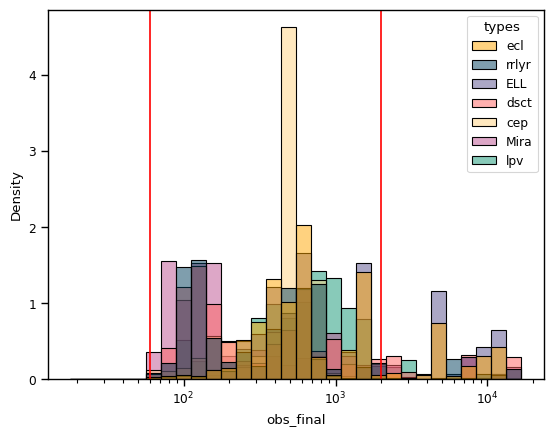

In [242]:
catalog = catalog.loc[(catalog["obs_final"]!=0)] 
sns.histplot(data=catalog,x="obs_final",bins=30,hue="types"
             ,palette=sns.color_palette(gyr),log_scale=True,
    stat="density", common_norm=False)
plt.axvline(x=2000, color = 'r')
plt.axvline(x=60, color = 'r')
plt.savefig("paper_observaciones_final.pdf")

In [243]:
df["Observaciones<60"] = catalog.loc[(catalog["obs_final"]<=60)|
                                     (catalog["obs_final"]==0)
                                    ].groupby("types").count()[["ID"]]

In [244]:
catalog = catalog.loc[(catalog["obs_final"]>60)] # aproximadamente 1 % de la mmuestra

<AxesSubplot: ylabel='Count'>

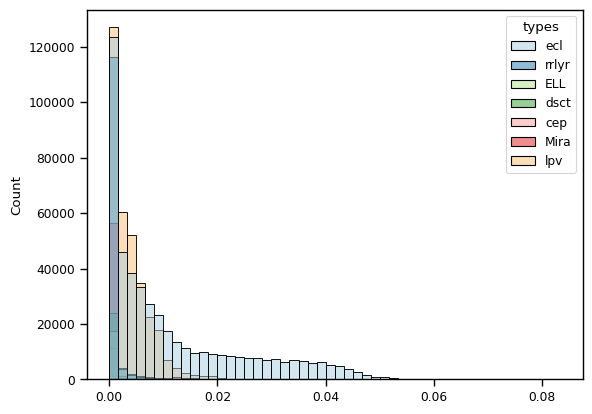

In [245]:
sns.histplot(data=catalog,x=catalog["obs_eliminadas"] / catalog["obs_inicial"],bins=50,hue="types",palette="Paired")

In [246]:
catalog = catalog.sort_values(by="database",ascending=False).reset_index(drop=True)

In [247]:
df["Duplicated ID"] = catalog.loc[catalog.duplicated(subset="ID")].groupby("types").count()[["ID"]]

In [248]:
catalog = catalog.drop_duplicates(subset="ID",keep="first").reset_index(drop=True)

In [249]:
catalog.groupby("types").count()

,ID,RA,DEC,database,field,Subtype,per,error,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial,ra_deg,dec_deg
types,,,,,,,,,,,,,,,,,,
ELL,25926,25926,25926,25926,25926,0,25926,25926,25926,25926,25926,25926,25926,25926,25926,25926,25926,25926
Mira,63316,63316,63316,63316,63316,60004,63316,63316,63316,63316,63316,63316,63316,63316,63316,63316,63316,63316
cep,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445,11445
dsct,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259,29259
ecl,471790,471790,471790,471790,471790,471790,471772,471790,471790,471790,471790,471790,471790,471790,471790,471790,471790,471790
lpv,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486,334486
rrlyr,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189,124189


In [250]:
catalog.to_csv("catalogos/0_catalog_descriptivo_antes_de_topcat.csv")

In [251]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo_antes_de_topcat.csv")

In [252]:
catalog_t = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")

In [253]:
catalog_t = catalog_t.loc[catalog_t["GroupID"].isna()].drop(columns={"col1"}).reset_index(drop=True)

In [254]:
catalog.groupby("types").count()[["ID"]] - catalog_t.groupby("types").count()[["ID"]]

,ID
types,
ELL,483
Mira,34
cep,65
dsct,8
ecl,298
lpv,632
rrlyr,144


In [255]:
df["Topcat"] = catalog.groupby("types").count()[["ID"]] - catalog_t.groupby("types").count()[["ID"]]

In [256]:
df["final"] = catalog_t.groupby("types").count()[["ID"]]

In [257]:
df = df.fillna(0)


In [258]:
df["Catalogo"] - df["error download"] - df["Observaciones<60"] - df["Duplicated ID"] - df["Topcat"]

types
ELL       25443.0
Mira      63282.0
cep       11380.0
dsct      29251.0
ecl      471492.0
lpv      333854.0
rrlyr    124045.0
dtype: float64

In [260]:
catalog = catalog.loc[catalog["per"]!=0]

In [262]:
cep_min = catalog.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]

### Split Data

In [7]:

rng = np.random.default_rng(42)
datos = "/media/variablestars/datos1/datos_ogle/datos"
path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

In [8]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")

In [9]:
catalog = catalog.drop(columns={"col1"})
catalog = catalog.loc[catalog["per"]!=0]

In [10]:
cep_min = catalog.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]

In [13]:
df_split_random = split_random(catalog,cep_min,"entrenamiento_8mil_balanced")

In [14]:
df_split_data_balanced = split_data_balanced(catalog,cep_min)

In [15]:
df_split_data_balanced = df_split_data_balanced.loc[df_split_data_balanced["entrenamiento_8mil_balanced"].notna()]

In [17]:
#df_split_random = df_split_random.loc[df_split_random["entrenamiento_8mil_randm"].notna()]

In [18]:
#plot_obs_dist(df_split_random,"entrenamiento_8mil_randm")

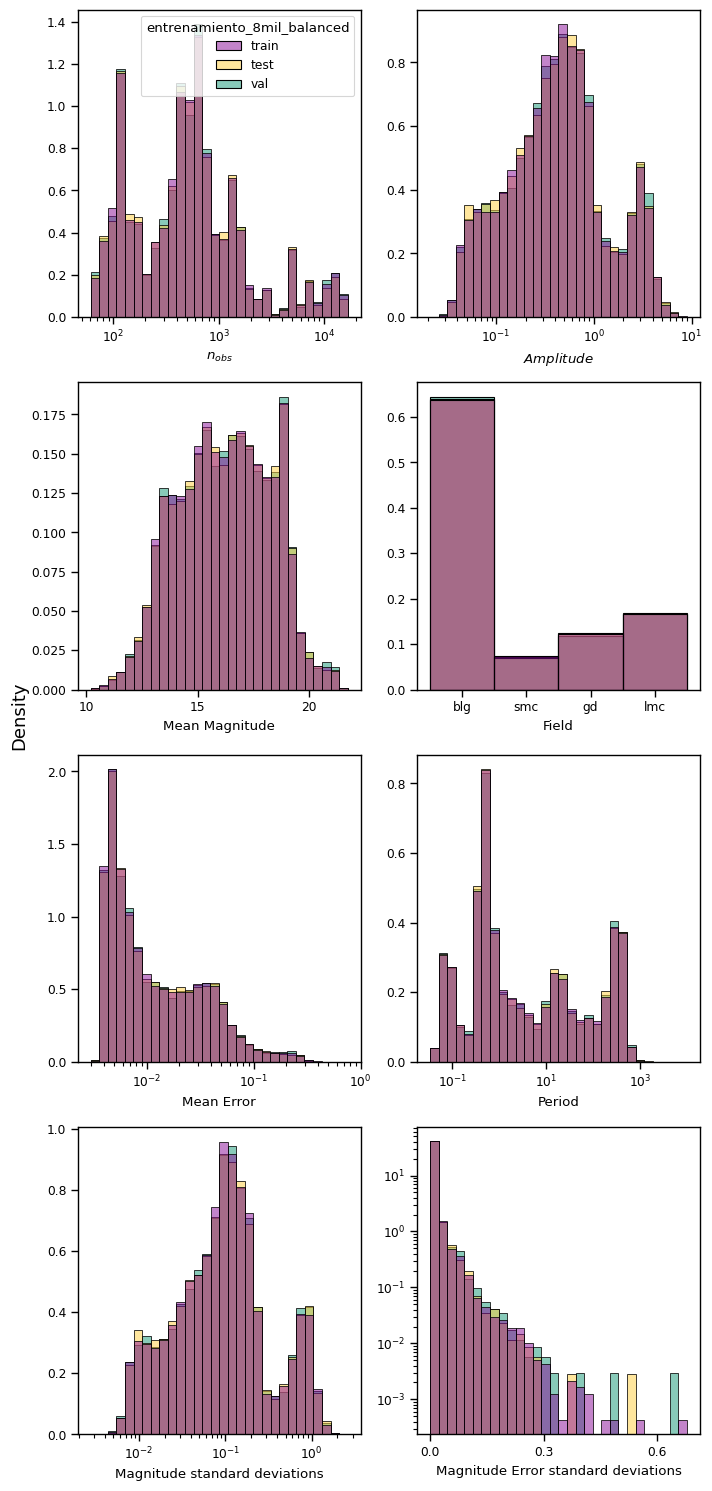

In [19]:
plot_obs_dist(df_split_data_balanced,"entrenamiento_8mil_balanced")

In [25]:
prueba_8mil = df_split_random.loc[df_split_random["entrenamiento_8mil_balanced"].notna()]

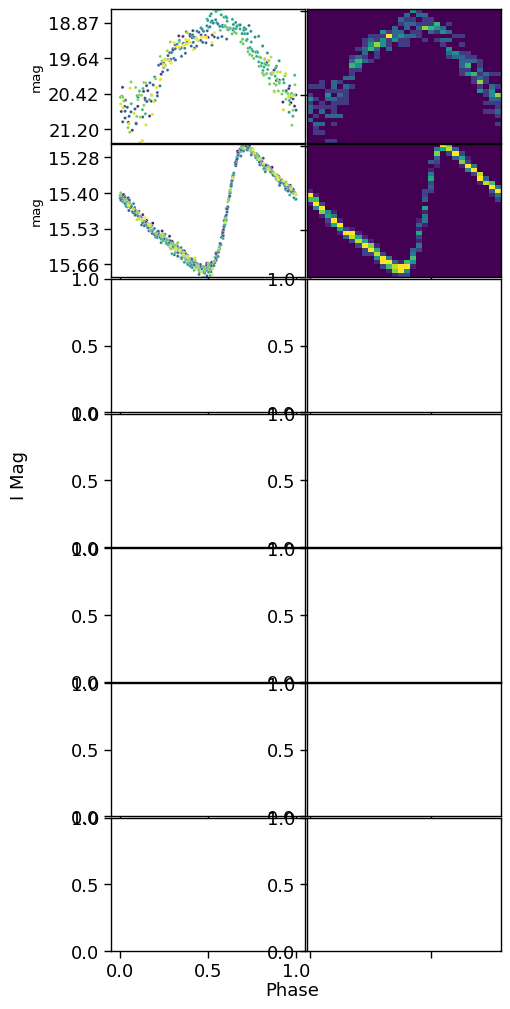

In [35]:

estrellas = ['OGLE-GD-RRLYR-04519', 'OGLE-BLG-LPV-240852', "OGLE-SMC-ECL-2344", "OGLE-LMC-CEP-2430", 'OGLE-LMC-LPV-83641', "OGLE-BLG-DSCT-00245", "OGLE-BLG-ELL-007122"]

a = plot_histograms(prueba_8mil, estrellas, path_datos,10)



## Augmented data

In [4]:
ogle = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")
ogle = ogle.drop(columns={"col1"})
ogle = ogle.loc[ogle["per"]!=0]
ogle = ogle[ogle["per"].notna()].reset_index(drop=True)
le = preprocessing.LabelEncoder()
le.fit(ogle.types)
ogle["categorical_label"] = le.transform(ogle.types)
cep_min = ogle.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]
ogle = split_random(ogle,cep_min,"prueba_8mil")
prueba_8mil = ogle.dropna(subset="prueba_8mil")

In [11]:

ogle = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")
ogle = ogle.drop(columns={"col1"})
ogle = ogle.loc[ogle["per"]!=0]
ogle = ogle[ogle["per"].notna()].reset_index(drop=True)
le = preprocessing.LabelEncoder()
le.fit(ogle.types)
ogle["categorical_label"] = le.transform(ogle.types)
cep_min = ogle.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]
ogle = split_random(ogle,cep_min,"prueba_8mil")
prueba_8mil = ogle.dropna(subset="prueba_8mil")

ogle = ogle[~ogle["ID"].isin(prueba_8mil["ID"])].reset_index(drop=True)

prueba_23_mil = pd.DataFrame()
for types in ogle["types"].unique():
    df_types = ogle.loc[ogle["types"]==types].reset_index(drop=True)
    if len(df_types)> 15065:
        df_types = df_types.sample(15065,random_state=42).reset_index(drop=True)
    prueba_23_mil = pd.concat([prueba_23_mil,df_types])

train_8mil = prueba_8mil.loc[prueba_8mil["prueba_8mil"] == "train"].reset_index(drop=True)

prueba_23_mil = pd.concat([prueba_23_mil,train_8mil])

for types in prueba_23_mil["types"].unique():
    df_types = prueba_23_mil.loc[prueba_23_mil["types"]==types].reset_index(drop=True)
    resto = 24168 % len(df_types)
    if 24168 // len(df_types) > 1:
        repetir = 24168 // len(df_types) -1 
        prueba_23_mil = pd.concat([prueba_23_mil,pd.concat([df_types]*repetir)])
        prueba_23_mil = pd.concat([prueba_23_mil,df_types.sample(resto,random_state=42)])
    if 24168 // len(df_types) == 1:
        prueba_23_mil = pd.concat([prueba_23_mil,df_types.sample(resto,random_state=42)])
    

ogle = ogle[~ogle["ID"].isin(prueba_23_mil["ID"])].reset_index(drop=True)
ogle.groupby("types").count()

prueba_60_mil = pd.DataFrame()
for types in ogle["types"].unique():
    df_types = ogle.loc[ogle["types"]==types].reset_index(drop=True)
    if len(df_types)>= 36838:
        df_types = df_types.sample(36838,random_state=42).reset_index(drop=True)
    prueba_60_mil = pd.concat([prueba_60_mil,df_types])

prueba_60_mil = pd.concat([prueba_60_mil,prueba_23_mil],axis=0)

for types in prueba_60_mil["types"].unique():
    df_types = prueba_60_mil.loc[prueba_60_mil["types"]==types].reset_index(drop=True)
    resto = 61006 % len(df_types)
    if 61006 // len(df_types) > 1:
        repetir = 61006 // len(df_types) -1
        prueba_60_mil = pd.concat([prueba_60_mil,pd.concat([df_types]*repetir)])
        prueba_60_mil = pd.concat([prueba_60_mil,df_types.sample(resto,random_state=42)])
    if 61006 // len(df_types) == 1:
        prueba_60_mil = pd.concat([prueba_60_mil,df_types.sample(resto,random_state=42)])

ogle = ogle[~ogle["ID"].isin(prueba_60_mil["ID"])].reset_index(drop=True)

prueba_23_mil.loc[prueba_23_mil.duplicated(subset="ID"),"aug"] = 1
prueba_23_mil.loc[prueba_23_mil["aug"].isna(),"aug"] = 0

prueba_60_mil.loc[prueba_60_mil.duplicated(subset="ID"),"aug"] = 1
prueba_60_mil.loc[prueba_60_mil["aug"].isna(),"aug"] = 0

df_aux = prueba_23_mil.groupby("ID").count()[["RA"]].reset_index().rename(columns={"RA":"count"})
prueba_23_mil = prueba_23_mil.merge(df_aux,how="left",on="ID")


df_aux = prueba_60_mil.groupby("ID").count()[["RA"]].reset_index().rename(columns={"RA":"count"})
prueba_60_mil = prueba_60_mil.merge(df_aux,how="left",on="ID")

prueba_23_mil.loc[prueba_23_mil["count"]>1].drop_duplicates(subset="ID").parallel_apply(lambda row: augmented_to(row["ID"],row["count"],prueba_23_mil),axis=1)
prueba_23_mil.loc[prueba_23_mil["aug"]==1,"bins"] = prueba_23_mil.loc[prueba_23_mil["aug"]==1].parallel_apply(lambda row: rng.choice(np.arange(int(row["obs_final"]*0.5),
                                           int(row["obs_final"]*0.7))),axis=1)
prueba_23_mil.loc[prueba_23_mil["bins"]>2000,"bins"] = rng.choice(np.arange(1000,1500),len(prueba_23_mil.loc[prueba_23_mil["bins"]>2000]))
prueba_23_mil_sin_aug = prueba_23_mil.loc[prueba_23_mil["aug"]==0].reset_index(drop=True)

prueba_60_mil.loc[prueba_60_mil["count"]>1].drop_duplicates(subset="ID").parallel_apply(lambda row: augmented_to(row["ID"],row["count"],prueba_60_mil),axis=1)
prueba_60_mil.loc[prueba_60_mil["aug"]==1,"bins"] = prueba_60_mil.loc[prueba_60_mil["aug"]==1].parallel_apply(lambda row: rng.choice(np.arange(int(row["obs_final"]*0.5),
                                           int(row["obs_final"]*0.8))),axis=1)
prueba_60_mil.loc[prueba_60_mil["bins"]>2000,"bins"] = rng.choice(np.arange(1000,1500),len(prueba_60_mil.loc[prueba_60_mil["bins"]>2000]))
prueba_60_mil_sin_aug = prueba_60_mil.loc[prueba_60_mil["aug"]==0].reset_index(drop=True)


In [20]:
prueba_8mil["aug"] = 0
prueba_8mil["g"] = np.nan
prueba_8mil["bins"] = np.nan
prueba_8mil["N"] = np.nan

ogle["aug"] = 0
ogle["g"] = np.nan
ogle["bins"] = np.nan
ogle["N"] = np.nan


prueba_23_mil["g"] = rng.uniform(low=0 + 1/32, high=1 - 1/32, size=len(prueba_23_mil))*prueba_23_mil["per"]
prueba_60_mil["g"] = rng.uniform(low=0 + 1/32, high=1 - 1/32, size=len(prueba_60_mil))*prueba_60_mil["per"]

valores = [5, 7, 9, 11, 13, 15]

prueba_23_mil["N"] = np.random.choice(valores, len(prueba_23_mil)) 
prueba_60_mil["N"] = np.random.choice(valores, len(prueba_60_mil)) 

In [23]:
prueba_23_mil.loc[prueba_23_mil["prueba_8mil"].isna(),"prueba_8mil"] = "train"
prueba_60_mil.loc[prueba_60_mil["prueba_8mil"].isna(),"prueba_8mil"] = "train"

In [16]:

def randomize_per(group):
    size = len(group)
    low = group['per'].min()
    high = group['per'].max()
    group['per'] = np.random.uniform(low=low, high=high, size=size)
    return group


def make_random_period(df,n_star_split="auto"):
    if n_star_split=="auto":
        for split in ["train","val","test"]:
            df_var = df.loc[(df["prueba_8mil"]==split)&(df["aug"]==0)]
            n_star_split = df_var.groupby("categorical_label").count()["ID"].max()
            if np.isnan(n_star_split):
                continue
            if int(n_star_split) <= df_var.groupby("types").count()["ID"].min():
                df_randoms = df_var.groupby("types").sample(int(np.ceil(n_star_split/7)))
                df_randoms = df_randoms.sample(n_star_split)
            else:
                df_randoms = df_var.groupby("types").sample(int(df_var.groupby("types").count()["ID"].min()/7))
                resto = df_var.drop(df_randoms.index, errors='ignore').sample(n_star_split - len(df_randoms))
                df_randoms = pd.concat([df_randoms,resto])
            df_randoms["categorical_label"] = 7
            df_randoms = df_randoms.groupby('types', group_keys=True).apply(randomize_per).reset_index(drop=True)
            df_randoms["types"] = df_randoms["types"] +"_"+ "random"
            df = pd.concat([df,df_randoms])
    else:
        for split in ["train"]:
            df_var = df.loc[(df["prueba_8mil"]==split)&(df["aug"]==0)]
            if np.isnan(n_star_split):
                continue
            if int(n_star_split) <= df_var.groupby("types").count()["ID"].min():
                df_randoms = df_var.groupby("types").sample(int(np.ceil(n_star_split/7)))
                df_randoms = df_randoms.sample(n_star_split)
            else:
                df_randoms = df_var.groupby("types").sample(int(df_var.groupby("types").count()["ID"].min()/7))
                resto = df_var.drop(df_randoms.index, errors='ignore').sample(n_star_split - len(df_randoms))
                df_randoms = pd.concat([df_randoms,resto])
            df_randoms["categorical_label"] = 7
            df_randoms = df_randoms.groupby('types', group_keys=True).apply(randomize_per).reset_index(drop=True)
            df_randoms["types"] = df_randoms["types"] +"_"+ "random"
            df = pd.concat([df,df_randoms])

    return df
    
    

In [24]:
prueba_8mil_2 = make_random_period(prueba_8mil)
prueba_23_mil_2 =  make_random_period(prueba_23_mil,24168)
prueba_60_mil_2 =  make_random_period(prueba_60_mil,61006)

In [26]:
prueba_60_mil_2.to_csv("catalogos/prueba_60mil.csv",index=False)
prueba_23_mil_2.to_csv("catalogos/prueba_23mil.csv",index=False)
prueba_8mil_2.to_csv("catalogos/prueba_8mil.csv",index=False)
ogle.to_csv("catalogos/ogle_no_usado.csv",index=False)

### Hacer HDF5 

In [3]:
ray.shutdown()

In [5]:
ray.init()

2023-09-08 21:45:32,220	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.6.3


In [3]:
prueba_60_mil = pd.read_csv("catalogos/prueba_60mil.csv")
prueba_23_mil= pd.read_csv("catalogos/prueba_23mil.csv")
prueba_8mil = pd.read_csv("catalogos/prueba_8mil.csv")
ogle = pd.read_csv("catalogos/ogle_no_usado.csv")

In [8]:
data_total = h5py.File('Data_08Sep.hdf5', 'w')
for test in [prueba_8mil,prueba_23_mil,prueba_60_mil,ogle]:
    data_hist = create_hdf5(test,path_datos,rng)
    name = int(len(test)/7)
    data_total.create_dataset(f'prueba_{str(name)}mil_label', data=test['categorical_label'])
    data_total.create_dataset(f'prueba_{str(name)}mil', data=data_hist)

In [10]:
data_total = h5py.File('Data_08Sep.hdf5', 'r+')


In [25]:
data_total.close()

## Entrenar

In [3]:
prueba_60_mil = pd.read_csv("catalogos/prueba_60mil.csv")
prueba_23_mil= pd.read_csv("catalogos/prueba_23mil.csv")
prueba_8mil = pd.read_csv("catalogos/prueba_8mil.csv")
ogle = pd.read_csv("catalogos/ogle_no_usado.csv")

In [4]:
data = h5py.File("Data_08Sep.hdf5", 'r+')

In [5]:
prueba_8mil = prueba_8mil.rename(columns={"prueba_8mil":"prueba_13080mil"})
prueba_23_mil = prueba_23_mil.rename(columns={"prueba_8mil":"prueba_27620mil"})
prueba_60_mil = prueba_60_mil.rename(columns={"prueba_8mil":"prueba_69721mil"})

In [6]:
df_lista = [prueba_8mil,prueba_23_mil,prueba_60_mil]
keys_lista = ['prueba_13080mil','prueba_27620mil','prueba_69721mil']

In [7]:
cd entrenamiento_8_sep/

/workspace/ogle_06_03_23/entrenamiento_8_sep


In [16]:
train_models(df_lista, keys_lista, data, prueba_8mil,epochs=600)

Use balanced Generator [False] 
 Data: 67704 
 -----------------------------------------------------------------------------------
Epoch 1/600
1058/1058 [==============================] - ETA: 0s - loss: 2.0769 - acc: 0.1253
Epoch 1: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 11s 8ms/step - loss: 2.0769 - acc: 0.1253 - val_loss: 2.0739 - val_acc: 0.1419
Epoch 2/600
1050/1058 [============================>.] - ETA: 0s - loss: 2.0716 - acc: 0.1618
Epoch 2: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 7ms/step - loss: 2.0716 - acc: 0.1620 - val_loss: 2.0664 - val_acc: 0.1796
Epoch 3/600
1050/1058 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.1859
Epoch 3: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 7ms/step - loss: 2.0625 - acc: 0.1859 - val_loss: 2.0511 - val_acc: 0.2016
Epoch 4/600
1055/10

1058/1058 [==============================] - 9s 8ms/step - loss: 0.5699 - acc: 0.8037 - val_loss: 0.4934 - val_acc: 0.8302
Epoch 30/600
1055/1058 [============================>.] - ETA: 0s - loss: 0.5639 - acc: 0.8064
Epoch 30: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.5636 - acc: 0.8065 - val_loss: 0.4844 - val_acc: 0.8327
Epoch 31/600
1052/1058 [============================>.] - ETA: 0s - loss: 0.5581 - acc: 0.8066
Epoch 31: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 7ms/step - loss: 0.5583 - acc: 0.8066 - val_loss: 0.4821 - val_acc: 0.8350
Epoch 32/600
1055/1058 [============================>.] - ETA: 0s - loss: 0.5464 - acc: 0.8095
Epoch 32: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.5463 - acc: 0.8095 - val_loss: 0.4744 - val_acc: 0.8362
Epoch 33/600
1052/1058

1058/1058 [==============================] - ETA: 0s - loss: 0.4405 - acc: 0.8428
Epoch 58: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.4405 - acc: 0.8428 - val_loss: 0.3962 - val_acc: 0.8599
Epoch 59/600
1054/1058 [============================>.] - ETA: 0s - loss: 0.4396 - acc: 0.8439
Epoch 59: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.4398 - acc: 0.8438 - val_loss: 0.3961 - val_acc: 0.8609
Epoch 60/600
1056/1058 [============================>.] - ETA: 0s - loss: 0.4363 - acc: 0.8451
Epoch 60: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.4364 - acc: 0.8451 - val_loss: 0.3906 - val_acc: 0.8643
Epoch 61/600
1053/1058 [============================>.] - ETA: 0s - loss: 0.4353 - acc: 0.8451
Epoch 61: saving model to training_softmax_prueba_13080mil/cp.c

Epoch 87/600
1055/1058 [============================>.] - ETA: 0s - loss: 0.3833 - acc: 0.8652
Epoch 87: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.3836 - acc: 0.8651 - val_loss: 0.3543 - val_acc: 0.8792
Epoch 88/600
1058/1058 [==============================] - ETA: 0s - loss: 0.3826 - acc: 0.8641
Epoch 88: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 9ms/step - loss: 0.3826 - acc: 0.8641 - val_loss: 0.3581 - val_acc: 0.8782
Epoch 89/600
1057/1058 [============================>.] - ETA: 0s - loss: 0.3796 - acc: 0.8651
Epoch 89: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.3797 - acc: 0.8650 - val_loss: 0.3536 - val_acc: 0.8787
Epoch 90/600
1053/1058 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.8682
Epoch 90: saving model to training_softmax_prueba_

Epoch 116/600
1056/1058 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8787
Epoch 116: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 9ms/step - loss: 0.3422 - acc: 0.8786 - val_loss: 0.3298 - val_acc: 0.8890
Epoch 117/600
1057/1058 [============================>.] - ETA: 0s - loss: 0.3396 - acc: 0.8800
Epoch 117: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.3395 - acc: 0.8800 - val_loss: 0.3312 - val_acc: 0.8875
Epoch 118/600
1052/1058 [============================>.] - ETA: 0s - loss: 0.3403 - acc: 0.8790
Epoch 118: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.3402 - acc: 0.8791 - val_loss: 0.3290 - val_acc: 0.8878
Epoch 119/600
1058/1058 [==============================] - ETA: 0s - loss: 0.3403 - acc: 0.8800
Epoch 119: saving model to training_softmax

1058/1058 [==============================] - 8s 8ms/step - loss: 0.3136 - acc: 0.8890 - val_loss: 0.3161 - val_acc: 0.8921
Epoch 145/600
1050/1058 [============================>.] - ETA: 0s - loss: 0.3113 - acc: 0.8906
Epoch 145: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.3116 - acc: 0.8904 - val_loss: 0.3133 - val_acc: 0.8954
Epoch 146/600
1058/1058 [==============================] - ETA: 0s - loss: 0.3083 - acc: 0.8915
Epoch 146: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 7ms/step - loss: 0.3083 - acc: 0.8915 - val_loss: 0.3154 - val_acc: 0.8939
Epoch 147/600
1057/1058 [============================>.] - ETA: 0s - loss: 0.3138 - acc: 0.8887
Epoch 147: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.3138 - acc: 0.8887 - val_loss: 0.3223 - val_acc: 0.8908
Epoch 148/600
10

1054/1058 [============================>.] - ETA: 0s - loss: 0.2881 - acc: 0.8982
Epoch 173: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 9ms/step - loss: 0.2881 - acc: 0.8982 - val_loss: 0.3056 - val_acc: 0.8986
Epoch 174/600
1042/1058 [============================>.] - ETA: 0s - loss: 0.2862 - acc: 0.8975
Epoch 174: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.2855 - acc: 0.8977 - val_loss: 0.3118 - val_acc: 0.8969
Epoch 175/600
1056/1058 [============================>.] - ETA: 0s - loss: 0.2867 - acc: 0.8989
Epoch 175: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.2866 - acc: 0.8989 - val_loss: 0.3082 - val_acc: 0.8972
Epoch 176/600
1055/1058 [============================>.] - ETA: 0s - loss: 0.2849 - acc: 0.8990
Epoch 176: saving model to training_softmax_prueba_13080m

Epoch 202/600
1054/1058 [============================>.] - ETA: 0s - loss: 0.2644 - acc: 0.9062
Epoch 202: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.2642 - acc: 0.9063 - val_loss: 0.2991 - val_acc: 0.9004
Epoch 203/600
1054/1058 [============================>.] - ETA: 0s - loss: 0.2629 - acc: 0.9069
Epoch 203: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 8s 8ms/step - loss: 0.2632 - acc: 0.9068 - val_loss: 0.3017 - val_acc: 0.8995
Epoch 204/600
1056/1058 [============================>.] - ETA: 0s - loss: 0.2633 - acc: 0.9054
Epoch 204: saving model to training_softmax_prueba_13080mil/cp.ckpt
1058/1058 [==============================] - 9s 8ms/step - loss: 0.2635 - acc: 0.9053 - val_loss: 0.3049 - val_acc: 0.9003
Epoch 205/600
1056/1058 [============================>.] - ETA: 0s - loss: 0.2609 - acc: 0.9074
Epoch 205: saving model to training_softmax

1062/1063 [============================>.] - ETA: 0s - loss: 0.6153 - acc: 0.7930
Epoch 23: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 5ms/step - loss: 0.6152 - acc: 0.7930 - val_loss: 0.5250 - val_acc: 0.8230
Epoch 24/600
1058/1063 [============================>.] - ETA: 0s - loss: 0.6067 - acc: 0.7946
Epoch 24: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 5ms/step - loss: 0.6068 - acc: 0.7946 - val_loss: 0.5141 - val_acc: 0.8268
Epoch 25/600
1055/1063 [============================>.] - ETA: 0s - loss: 0.5971 - acc: 0.7971
Epoch 25: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.5971 - acc: 0.7971 - val_loss: 0.5093 - val_acc: 0.8252
Epoch 26/600
1050/1063 [============================>.] - ETA: 0s - loss: 0.5897 - acc: 0.7992
Epoch 26: saving model to training_softmax_prueba_27620mil/cp.c

Epoch 52/600
1063/1063 [==============================] - ETA: 0s - loss: 0.4667 - acc: 0.8375
Epoch 52: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.4667 - acc: 0.8375 - val_loss: 0.4090 - val_acc: 0.8550
Epoch 53/600
1062/1063 [============================>.] - ETA: 0s - loss: 0.4646 - acc: 0.8379
Epoch 53: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.4645 - acc: 0.8380 - val_loss: 0.4121 - val_acc: 0.8541
Epoch 54/600
1060/1063 [============================>.] - ETA: 0s - loss: 0.4593 - acc: 0.8392
Epoch 54: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.4595 - acc: 0.8391 - val_loss: 0.4069 - val_acc: 0.8558
Epoch 55/600
1055/1063 [============================>.] - ETA: 0s - loss: 0.4579 - acc: 0.8405
Epoch 55: saving model to training_softmax_prueba_

Epoch 81/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.4084 - acc: 0.8574
Epoch 81: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.4083 - acc: 0.8574 - val_loss: 0.3662 - val_acc: 0.8754
Epoch 82/600
1063/1063 [==============================] - ETA: 0s - loss: 0.4050 - acc: 0.8586
Epoch 82: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 5ms/step - loss: 0.4050 - acc: 0.8586 - val_loss: 0.3625 - val_acc: 0.8757
Epoch 83/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.4047 - acc: 0.8590
Epoch 83: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 5ms/step - loss: 0.4045 - acc: 0.8590 - val_loss: 0.3622 - val_acc: 0.8765
Epoch 84/600
1053/1063 [============================>.] - ETA: 0s - loss: 0.4032 - acc: 0.8597
Epoch 84: saving model to training_softmax_prueba_

Epoch 110/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.3706 - acc: 0.8714
Epoch 110: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 7s 6ms/step - loss: 0.3706 - acc: 0.8714 - val_loss: 0.3377 - val_acc: 0.8870
Epoch 111/600
1050/1063 [============================>.] - ETA: 0s - loss: 0.3700 - acc: 0.8718
Epoch 111: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 5s 5ms/step - loss: 0.3700 - acc: 0.8718 - val_loss: 0.3392 - val_acc: 0.8847
Epoch 112/600
1053/1063 [============================>.] - ETA: 0s - loss: 0.3683 - acc: 0.8718
Epoch 112: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 5s 5ms/step - loss: 0.3683 - acc: 0.8719 - val_loss: 0.3377 - val_acc: 0.8862
Epoch 113/600
1063/1063 [==============================] - ETA: 0s - loss: 0.3670 - acc: 0.8723
Epoch 113: saving model to training_softmax

1063/1063 [==============================] - 5s 5ms/step - loss: 0.3444 - acc: 0.8803 - val_loss: 0.3229 - val_acc: 0.8925
Epoch 139/600
1059/1063 [============================>.] - ETA: 0s - loss: 0.3433 - acc: 0.8807
Epoch 139: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3432 - acc: 0.8808 - val_loss: 0.3187 - val_acc: 0.8930
Epoch 140/600
1063/1063 [==============================] - ETA: 0s - loss: 0.3435 - acc: 0.8813
Epoch 140: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3435 - acc: 0.8813 - val_loss: 0.3193 - val_acc: 0.8935
Epoch 141/600
1054/1063 [============================>.] - ETA: 0s - loss: 0.3438 - acc: 0.8799
Epoch 141: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 5ms/step - loss: 0.3437 - acc: 0.8800 - val_loss: 0.3183 - val_acc: 0.8937
Epoch 142/600
10

1061/1063 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.8879
Epoch 167: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3236 - acc: 0.8879 - val_loss: 0.3080 - val_acc: 0.8952
Epoch 168/600
1063/1063 [==============================] - ETA: 0s - loss: 0.3230 - acc: 0.8879
Epoch 168: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3230 - acc: 0.8879 - val_loss: 0.3082 - val_acc: 0.8963
Epoch 169/600
1063/1063 [==============================] - ETA: 0s - loss: 0.3232 - acc: 0.8880
Epoch 169: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 5s 5ms/step - loss: 0.3232 - acc: 0.8880 - val_loss: 0.3079 - val_acc: 0.8969
Epoch 170/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.3200 - acc: 0.8895
Epoch 170: saving model to training_softmax_prueba_27620m

Epoch 196/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.3077 - acc: 0.8930
Epoch 196: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3078 - acc: 0.8929 - val_loss: 0.2989 - val_acc: 0.9011
Epoch 197/600
1056/1063 [============================>.] - ETA: 0s - loss: 0.3064 - acc: 0.8932
Epoch 197: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3063 - acc: 0.8932 - val_loss: 0.2974 - val_acc: 0.8995
Epoch 198/600
1062/1063 [============================>.] - ETA: 0s - loss: 0.3057 - acc: 0.8935
Epoch 198: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.3057 - acc: 0.8936 - val_loss: 0.2979 - val_acc: 0.9008
Epoch 199/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.3066 - acc: 0.8935
Epoch 199: saving model to training_softmax

1063/1063 [==============================] - 5s 5ms/step - loss: 0.2919 - acc: 0.8983 - val_loss: 0.2933 - val_acc: 0.9007
Epoch 225/600
1056/1063 [============================>.] - ETA: 0s - loss: 0.2929 - acc: 0.8984
Epoch 225: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 5s 5ms/step - loss: 0.2929 - acc: 0.8984 - val_loss: 0.2904 - val_acc: 0.9018
Epoch 226/600
1058/1063 [============================>.] - ETA: 0s - loss: 0.2934 - acc: 0.8978
Epoch 226: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2934 - acc: 0.8978 - val_loss: 0.2911 - val_acc: 0.9024
Epoch 227/600
1060/1063 [============================>.] - ETA: 0s - loss: 0.2916 - acc: 0.8980
Epoch 227: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2916 - acc: 0.8980 - val_loss: 0.2871 - val_acc: 0.9055
Epoch 228/600
10

1056/1063 [============================>.] - ETA: 0s - loss: 0.2810 - acc: 0.9021
Epoch 253: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 5s 5ms/step - loss: 0.2810 - acc: 0.9021 - val_loss: 0.2818 - val_acc: 0.9066
Epoch 254/600
1059/1063 [============================>.] - ETA: 0s - loss: 0.2809 - acc: 0.9024
Epoch 254: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2809 - acc: 0.9025 - val_loss: 0.2845 - val_acc: 0.9043
Epoch 255/600
1062/1063 [============================>.] - ETA: 0s - loss: 0.2801 - acc: 0.9021
Epoch 255: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2800 - acc: 0.9021 - val_loss: 0.2835 - val_acc: 0.9055
Epoch 256/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.2772 - acc: 0.9033
Epoch 256: saving model to training_softmax_prueba_27620m

Epoch 282/600
1062/1063 [============================>.] - ETA: 0s - loss: 0.2686 - acc: 0.9061
Epoch 282: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2685 - acc: 0.9061 - val_loss: 0.2813 - val_acc: 0.9070
Epoch 283/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.2684 - acc: 0.9066
Epoch 283: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2684 - acc: 0.9066 - val_loss: 0.2864 - val_acc: 0.9055
Epoch 284/600
1059/1063 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.9060
Epoch 284: saving model to training_softmax_prueba_27620mil/cp.ckpt
1063/1063 [==============================] - 6s 6ms/step - loss: 0.2693 - acc: 0.9060 - val_loss: 0.2823 - val_acc: 0.9060
Epoch 285/600
1061/1063 [============================>.] - ETA: 0s - loss: 0.2672 - acc: 0.9077
Epoch 285: saving model to training_softmax

1063/1063 [==============================] - 6s 6ms/step - loss: 0.2593 - acc: 0.9102 - val_loss: 0.2798 - val_acc: 0.9069
Epoch 310: early stopping
Use balanced Generator [False] 
 Data: 488048 
 -----------------------------------------------------------------------------------
Epoch 1/600
1053/1059 [============================>.] - ETA: 0s - loss: 2.0770 - acc: 0.1496
Epoch 1: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 2.0770 - acc: 0.1497 - val_loss: 2.0710 - val_acc: 0.2133
Epoch 2/600
1051/1059 [============================>.] - ETA: 0s - loss: 2.0647 - acc: 0.1956
Epoch 2: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 2.0646 - acc: 0.1958 - val_loss: 2.0525 - val_acc: 0.2424
Epoch 3/600
1051/1059 [============================>.] - ETA: 0s - loss: 2.0318 - acc: 0.2198
Epoch 3: saving model to training_softmax_prueba_69721mil/c

Epoch 29/600
1059/1059 [==============================] - ETA: 0s - loss: 0.5364 - acc: 0.8172
Epoch 29: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.5364 - acc: 0.8172 - val_loss: 0.5013 - val_acc: 0.8282
Epoch 30/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.5291 - acc: 0.8196
Epoch 30: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.5291 - acc: 0.8196 - val_loss: 0.4964 - val_acc: 0.8284
Epoch 31/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.5239 - acc: 0.8211
Epoch 31: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.5239 - acc: 0.8212 - val_loss: 0.4898 - val_acc: 0.8325
Epoch 32/600
1051/1059 [============================>.] - ETA: 0s - loss: 0.5169 - acc: 0.8236
Epoch 32: saving model to training_softmax_prueba_

Epoch 58/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.4281 - acc: 0.8515
Epoch 58: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.4281 - acc: 0.8515 - val_loss: 0.4262 - val_acc: 0.8460
Epoch 59/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.4263 - acc: 0.8517
Epoch 59: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.4262 - acc: 0.8517 - val_loss: 0.4265 - val_acc: 0.8462
Epoch 60/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.4240 - acc: 0.8525
Epoch 60: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.4241 - acc: 0.8525 - val_loss: 0.4191 - val_acc: 0.8497
Epoch 61/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.4212 - acc: 0.8537
Epoch 61: saving model to training_softmax_prueba_

Epoch 87/600
1051/1059 [============================>.] - ETA: 0s - loss: 0.3815 - acc: 0.8676
Epoch 87: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.3815 - acc: 0.8676 - val_loss: 0.3836 - val_acc: 0.8624
Epoch 88/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.3799 - acc: 0.8678
Epoch 88: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3798 - acc: 0.8679 - val_loss: 0.3850 - val_acc: 0.8642
Epoch 89/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.3787 - acc: 0.8682
Epoch 89: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.3786 - acc: 0.8682 - val_loss: 0.3821 - val_acc: 0.8637
Epoch 90/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.3780 - acc: 0.8685
Epoch 90: saving model to training_softmax_prueba_

Epoch 116/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.3530 - acc: 0.8770
Epoch 116: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.3529 - acc: 0.8770 - val_loss: 0.3640 - val_acc: 0.8691
Epoch 117/600
1056/1059 [============================>.] - ETA: 0s - loss: 0.3521 - acc: 0.8777
Epoch 117: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3520 - acc: 0.8777 - val_loss: 0.3650 - val_acc: 0.8709
Epoch 118/600
1051/1059 [============================>.] - ETA: 0s - loss: 0.3515 - acc: 0.8775
Epoch 118: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3515 - acc: 0.8775 - val_loss: 0.3610 - val_acc: 0.8722
Epoch 119/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.3503 - acc: 0.8784
Epoch 119: saving model to training_softmax

1059/1059 [==============================] - 7s 7ms/step - loss: 0.3332 - acc: 0.8843 - val_loss: 0.3490 - val_acc: 0.8798
Epoch 145/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.3334 - acc: 0.8844
Epoch 145: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3333 - acc: 0.8844 - val_loss: 0.3462 - val_acc: 0.8794
Epoch 146/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.3311 - acc: 0.8851
Epoch 146: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3312 - acc: 0.8851 - val_loss: 0.3451 - val_acc: 0.8804
Epoch 147/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.3310 - acc: 0.8848
Epoch 147: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3310 - acc: 0.8848 - val_loss: 0.3477 - val_acc: 0.8783
Epoch 148/600
10

1053/1059 [============================>.] - ETA: 0s - loss: 0.3168 - acc: 0.8901
Epoch 173: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.3167 - acc: 0.8901 - val_loss: 0.3401 - val_acc: 0.8815
Epoch 174/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.3158 - acc: 0.8903
Epoch 174: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.3159 - acc: 0.8903 - val_loss: 0.3330 - val_acc: 0.8849
Epoch 175/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.3149 - acc: 0.8906
Epoch 175: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3150 - acc: 0.8906 - val_loss: 0.3422 - val_acc: 0.8808
Epoch 176/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.3149 - acc: 0.8911
Epoch 176: saving model to training_softmax_prueba_69721m

Epoch 202/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.3022 - acc: 0.8954
Epoch 202: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3023 - acc: 0.8953 - val_loss: 0.3290 - val_acc: 0.8860
Epoch 203/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.3030 - acc: 0.8948
Epoch 203: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3030 - acc: 0.8948 - val_loss: 0.3250 - val_acc: 0.8891
Epoch 204/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.3027 - acc: 0.8953
Epoch 204: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.3028 - acc: 0.8952 - val_loss: 0.3247 - val_acc: 0.8884
Epoch 205/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.3020 - acc: 0.8954
Epoch 205: saving model to training_softmax

1059/1059 [==============================] - 8s 7ms/step - loss: 0.2917 - acc: 0.8986 - val_loss: 0.3113 - val_acc: 0.8946
Epoch 231/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.2917 - acc: 0.8986
Epoch 231: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2917 - acc: 0.8986 - val_loss: 0.3212 - val_acc: 0.8908
Epoch 232/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.2906 - acc: 0.8993
Epoch 232: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.2905 - acc: 0.8994 - val_loss: 0.3122 - val_acc: 0.8957
Epoch 233/600
1052/1059 [============================>.] - ETA: 0s - loss: 0.2916 - acc: 0.8990
Epoch 233: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2916 - acc: 0.8990 - val_loss: 0.3132 - val_acc: 0.8938
Epoch 234/600
10

1051/1059 [============================>.] - ETA: 0s - loss: 0.2821 - acc: 0.9028
Epoch 259: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.2823 - acc: 0.9027 - val_loss: 0.3091 - val_acc: 0.8954
Epoch 260/600
1059/1059 [==============================] - ETA: 0s - loss: 0.2823 - acc: 0.9024
Epoch 260: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2823 - acc: 0.9024 - val_loss: 0.3100 - val_acc: 0.8947
Epoch 261/600
1056/1059 [============================>.] - ETA: 0s - loss: 0.2815 - acc: 0.9028
Epoch 261: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2815 - acc: 0.9028 - val_loss: 0.3084 - val_acc: 0.8952
Epoch 262/600
1053/1059 [============================>.] - ETA: 0s - loss: 0.2809 - acc: 0.9025
Epoch 262: saving model to training_softmax_prueba_69721m

Epoch 288/600
1059/1059 [==============================] - ETA: 0s - loss: 0.2737 - acc: 0.9050
Epoch 288: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2737 - acc: 0.9050 - val_loss: 0.3008 - val_acc: 0.8983
Epoch 289/600
1059/1059 [==============================] - ETA: 0s - loss: 0.2734 - acc: 0.9056
Epoch 289: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2734 - acc: 0.9056 - val_loss: 0.3065 - val_acc: 0.8965
Epoch 290/600
1059/1059 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.9056
Epoch 290: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 8ms/step - loss: 0.2729 - acc: 0.9056 - val_loss: 0.3058 - val_acc: 0.8961
Epoch 291/600
1058/1059 [============================>.] - ETA: 0s - loss: 0.2724 - acc: 0.9058
Epoch 291: saving model to training_softmax

1059/1059 [==============================] - 8s 7ms/step - loss: 0.2658 - acc: 0.9080 - val_loss: 0.2980 - val_acc: 0.9001
Epoch 317/600
1055/1059 [============================>.] - ETA: 0s - loss: 0.2655 - acc: 0.9079
Epoch 317: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2656 - acc: 0.9079 - val_loss: 0.2996 - val_acc: 0.8992
Epoch 318/600
1056/1059 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.9082
Epoch 318: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.2656 - acc: 0.9082 - val_loss: 0.2954 - val_acc: 0.8990
Epoch 319/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.2651 - acc: 0.9081
Epoch 319: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2651 - acc: 0.9081 - val_loss: 0.2961 - val_acc: 0.9002
Epoch 320/600
10

1059/1059 [==============================] - ETA: 0s - loss: 0.2588 - acc: 0.9102
Epoch 345: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2588 - acc: 0.9102 - val_loss: 0.2922 - val_acc: 0.9013
Epoch 346/600
1059/1059 [==============================] - ETA: 0s - loss: 0.2585 - acc: 0.9110
Epoch 346: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2585 - acc: 0.9110 - val_loss: 0.2963 - val_acc: 0.8996
Epoch 347/600
1052/1059 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 0.9108
Epoch 347: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 7s 7ms/step - loss: 0.2584 - acc: 0.9108 - val_loss: 0.2975 - val_acc: 0.8982
Epoch 348/600
1057/1059 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.9109
Epoch 348: saving model to training_softmax_prueba_69721m

Epoch 374/600
1054/1059 [============================>.] - ETA: 0s - loss: 0.2524 - acc: 0.9122
Epoch 374: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2525 - acc: 0.9122 - val_loss: 0.2951 - val_acc: 0.8991
Epoch 375/600
1051/1059 [============================>.] - ETA: 0s - loss: 0.2516 - acc: 0.9134
Epoch 375: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2516 - acc: 0.9134 - val_loss: 0.2978 - val_acc: 0.8979
Epoch 376/600
1058/1059 [============================>.] - ETA: 0s - loss: 0.2513 - acc: 0.9131
Epoch 376: saving model to training_softmax_prueba_69721mil/cp.ckpt
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2513 - acc: 0.9131 - val_loss: 0.2905 - val_acc: 0.9011
Epoch 377/600
1051/1059 [============================>.] - ETA: 0s - loss: 0.2512 - acc: 0.9131
Epoch 377: saving model to training_softmax

In [17]:
train_models(df_lista, keys_lista, data, prueba_8mil,epochs=600, use_balanced_generator=True)

Use balanced Generator [True] 
 Data: 67704 
 -----------------------------------------------------------------------------------
Epoch 1/600
1052/1056 [============================>.] - ETA: 0s - loss: 2.0773 - acc: 0.1565
Epoch 1: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 2.0773 - acc: 0.1565 - val_loss: 2.0702 - val_acc: 0.1842
Epoch 2/600
1052/1056 [============================>.] - ETA: 0s - loss: 2.0631 - acc: 0.1883
Epoch 2: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 2.0631 - acc: 0.1883 - val_loss: 2.0465 - val_acc: 0.1862
Epoch 3/600
1050/1056 [============================>.] - ETA: 0s - loss: 2.0246 - acc: 0.2110
Epoch 3: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 9s 8ms/step - loss: 2.0244 - acc: 0.2112 - val_loss: 

Epoch 28/600
1056/1056 [==============================] - ETA: 0s - loss: 0.5399 - acc: 0.8145
Epoch 28: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.5399 - acc: 0.8145 - val_loss: 0.4715 - val_acc: 0.8384
Epoch 29/600
1050/1056 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.8168
Epoch 29: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.5313 - acc: 0.8168 - val_loss: 0.4651 - val_acc: 0.8429
Epoch 30/600
1056/1056 [==============================] - ETA: 0s - loss: 0.5241 - acc: 0.8186
Epoch 30: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.5241 - acc: 0.8186 - val_loss: 0.4613 - val_acc: 0.8421
Epoch 31/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.5190 - acc: 0.8201
Epoch 3

1052/1056 [============================>.] - ETA: 0s - loss: 0.4202 - acc: 0.8517
Epoch 55: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4203 - acc: 0.8517 - val_loss: 0.3834 - val_acc: 0.8667
Epoch 56/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.4179 - acc: 0.8525
Epoch 56: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4177 - acc: 0.8526 - val_loss: 0.3826 - val_acc: 0.8654
Epoch 57/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.4138 - acc: 0.8538
Epoch 57: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.4138 - acc: 0.8537 - val_loss: 0.3807 - val_acc: 0.8668
Epoch 58/600
1056/1056 [==============================] - ETA: 0s - loss: 0.4114 - acc: 0.8545
Epoch 58: saving 

1056/1056 [==============================] - 11s 10ms/step - loss: 0.3629 - acc: 0.8713 - val_loss: 0.3486 - val_acc: 0.8796
Epoch 83/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.3622 - acc: 0.8717
Epoch 83: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3621 - acc: 0.8717 - val_loss: 0.3474 - val_acc: 0.8810
Epoch 84/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.3603 - acc: 0.8723
Epoch 84: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3603 - acc: 0.8723 - val_loss: 0.3484 - val_acc: 0.8802
Epoch 85/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.3586 - acc: 0.8731
Epoch 85: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3588 - acc: 0.8731 - val_loss:

Epoch 110/600
1056/1056 [==============================] - ETA: 0s - loss: 0.3234 - acc: 0.8857
Epoch 110: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3234 - acc: 0.8857 - val_loss: 0.3279 - val_acc: 0.8891
Epoch 111/600
1056/1056 [==============================] - ETA: 0s - loss: 0.3215 - acc: 0.8859
Epoch 111: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3215 - acc: 0.8859 - val_loss: 0.3281 - val_acc: 0.8888
Epoch 112/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.3200 - acc: 0.8871
Epoch 112: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.3201 - acc: 0.8871 - val_loss: 0.3265 - val_acc: 0.8910
Epoch 113/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.3190 - acc: 0.8

1052/1056 [============================>.] - ETA: 0s - loss: 0.2931 - acc: 0.8960
Epoch 137: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2930 - acc: 0.8960 - val_loss: 0.3164 - val_acc: 0.8939
Epoch 138/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.2926 - acc: 0.8963
Epoch 138: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2926 - acc: 0.8963 - val_loss: 0.3154 - val_acc: 0.8937
Epoch 139/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.8970
Epoch 139: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2915 - acc: 0.8970 - val_loss: 0.3200 - val_acc: 0.8929
Epoch 140/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.2894 - acc: 0.8973
Epoch 140:

1052/1056 [============================>.] - ETA: 0s - loss: 0.2689 - acc: 0.9043
Epoch 164: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2689 - acc: 0.9044 - val_loss: 0.3079 - val_acc: 0.8985
Epoch 165/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2675 - acc: 0.9045
Epoch 165: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2675 - acc: 0.9045 - val_loss: 0.3088 - val_acc: 0.8982
Epoch 166/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.2678 - acc: 0.9044
Epoch 166: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2678 - acc: 0.9044 - val_loss: 0.3078 - val_acc: 0.8989
Epoch 167/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.9057
Epoch 167:

1049/1056 [============================>.] - ETA: 0s - loss: 0.2466 - acc: 0.9121
Epoch 191: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2466 - acc: 0.9121 - val_loss: 0.3057 - val_acc: 0.9003
Epoch 192/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2468 - acc: 0.9125
Epoch 192: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2467 - acc: 0.9125 - val_loss: 0.3047 - val_acc: 0.9002
Epoch 193/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.2460 - acc: 0.9117
Epoch 193: saving model to training_softmax_batchBalanced_prueba_13080mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2459 - acc: 0.9118 - val_loss: 0.3033 - val_acc: 0.9012
Epoch 194/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2451 - acc: 0.9126
Epoch 194: sa

Epoch 16/600
1048/1056 [============================>.] - ETA: 0s - loss: 0.7248 - acc: 0.7619
Epoch 16: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.7248 - acc: 0.7619 - val_loss: 0.6014 - val_acc: 0.8128
Epoch 17/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.7002 - acc: 0.7690
Epoch 17: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.7002 - acc: 0.7689 - val_loss: 0.5821 - val_acc: 0.8146
Epoch 18/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.6792 - acc: 0.7742
Epoch 18: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.6791 - acc: 0.7742 - val_loss: 0.5641 - val_acc: 0.8181
Epoch 19/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.6585 - acc: 0.7792
Epo

1051/1056 [============================>.] - ETA: 0s - loss: 0.4731 - acc: 0.8353
Epoch 43: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4732 - acc: 0.8353 - val_loss: 0.4080 - val_acc: 0.8568
Epoch 44/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.4692 - acc: 0.8370
Epoch 44: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.4692 - acc: 0.8370 - val_loss: 0.4075 - val_acc: 0.8558
Epoch 45/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.4659 - acc: 0.8380
Epoch 45: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4659 - acc: 0.8380 - val_loss: 0.4034 - val_acc: 0.8580
Epoch 46/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.4624 - acc: 0.8388
Epoch 46: savin

1056/1056 [==============================] - 10s 9ms/step - loss: 0.4038 - acc: 0.8595 - val_loss: 0.3580 - val_acc: 0.8773
Epoch 71/600
1056/1056 [==============================] - ETA: 0s - loss: 0.4016 - acc: 0.8602
Epoch 71: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.4016 - acc: 0.8602 - val_loss: 0.3567 - val_acc: 0.8778
Epoch 72/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3997 - acc: 0.8611
Epoch 72: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3997 - acc: 0.8611 - val_loss: 0.3550 - val_acc: 0.8778
Epoch 73/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.3986 - acc: 0.8619
Epoch 73: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 11s 11ms/step - loss: 0.3986 - acc: 0.8619 - val_loss:

Epoch 98/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3606 - acc: 0.8749
Epoch 98: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.3606 - acc: 0.8749 - val_loss: 0.3254 - val_acc: 0.8891
Epoch 99/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3608 - acc: 0.8748
Epoch 99: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3609 - acc: 0.8747 - val_loss: 0.3261 - val_acc: 0.8891
Epoch 100/600
1056/1056 [==============================] - ETA: 0s - loss: 0.3585 - acc: 0.8754
Epoch 100: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3585 - acc: 0.8754 - val_loss: 0.3248 - val_acc: 0.8901
Epoch 101/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.3568 - acc: 0.8767
E

1054/1056 [============================>.] - ETA: 0s - loss: 0.3330 - acc: 0.8845
Epoch 125: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3330 - acc: 0.8846 - val_loss: 0.3070 - val_acc: 0.8958
Epoch 126/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.3319 - acc: 0.8853
Epoch 126: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3319 - acc: 0.8853 - val_loss: 0.3063 - val_acc: 0.8970
Epoch 127/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.3310 - acc: 0.8850
Epoch 127: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3311 - acc: 0.8850 - val_loss: 0.3076 - val_acc: 0.8965
Epoch 128/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.3308 - acc: 0.8851
Epoch 128

1052/1056 [============================>.] - ETA: 0s - loss: 0.3108 - acc: 0.8924
Epoch 152: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3109 - acc: 0.8924 - val_loss: 0.2952 - val_acc: 0.8999
Epoch 153/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.3085 - acc: 0.8932
Epoch 153: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3085 - acc: 0.8932 - val_loss: 0.2952 - val_acc: 0.9008
Epoch 154/600
1056/1056 [==============================] - ETA: 0s - loss: 0.3097 - acc: 0.8925
Epoch 154: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.3097 - acc: 0.8925 - val_loss: 0.2945 - val_acc: 0.9010
Epoch 155/600
1050/1056 [============================>.] - ETA: 0s - loss: 0.3086 - acc: 0.8928
Epoch 155: sa

1054/1056 [============================>.] - ETA: 0s - loss: 0.2927 - acc: 0.8987
Epoch 179: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2927 - acc: 0.8987 - val_loss: 0.2880 - val_acc: 0.9011
Epoch 180/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2931 - acc: 0.8980
Epoch 180: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2931 - acc: 0.8980 - val_loss: 0.2850 - val_acc: 0.9035
Epoch 181/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.2913 - acc: 0.8990
Epoch 181: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2913 - acc: 0.8990 - val_loss: 0.2854 - val_acc: 0.9034
Epoch 182/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.8990
Epoch 182: 

1056/1056 [==============================] - ETA: 0s - loss: 0.2782 - acc: 0.9035
Epoch 206: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2782 - acc: 0.9035 - val_loss: 0.2829 - val_acc: 0.9044
Epoch 207/600
1050/1056 [============================>.] - ETA: 0s - loss: 0.2767 - acc: 0.9041
Epoch 207: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2767 - acc: 0.9041 - val_loss: 0.2795 - val_acc: 0.9053
Epoch 208/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2765 - acc: 0.9038
Epoch 208: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2765 - acc: 0.9038 - val_loss: 0.2803 - val_acc: 0.9054
Epoch 209/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2753 - acc: 0.9042
Epoch 209: sa

1049/1056 [============================>.] - ETA: 0s - loss: 0.2638 - acc: 0.9083
Epoch 233: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2638 - acc: 0.9083 - val_loss: 0.2736 - val_acc: 0.9078
Epoch 234/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2640 - acc: 0.9084
Epoch 234: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2640 - acc: 0.9084 - val_loss: 0.2720 - val_acc: 0.9088
Epoch 235/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.2633 - acc: 0.9081
Epoch 235: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2633 - acc: 0.9081 - val_loss: 0.2757 - val_acc: 0.9073
Epoch 236/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2625 - acc: 0.9085
Epoch 236: 

1056/1056 [==============================] - ETA: 0s - loss: 0.2518 - acc: 0.9123
Epoch 260: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2518 - acc: 0.9123 - val_loss: 0.2712 - val_acc: 0.9095
Epoch 261/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.2509 - acc: 0.9125
Epoch 261: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2509 - acc: 0.9125 - val_loss: 0.2683 - val_acc: 0.9093
Epoch 262/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.2508 - acc: 0.9129
Epoch 262: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2508 - acc: 0.9129 - val_loss: 0.2703 - val_acc: 0.9089
Epoch 263/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9122
Epoch 263: 

1049/1056 [============================>.] - ETA: 0s - loss: 0.2408 - acc: 0.9156
Epoch 287: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2407 - acc: 0.9156 - val_loss: 0.2686 - val_acc: 0.9106
Epoch 288/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2401 - acc: 0.9159
Epoch 288: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2401 - acc: 0.9159 - val_loss: 0.2689 - val_acc: 0.9108
Epoch 289/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2391 - acc: 0.9162
Epoch 289: saving model to training_softmax_batchBalanced_prueba_27620mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2391 - acc: 0.9162 - val_loss: 0.2657 - val_acc: 0.9117
Epoch 290/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2393 - acc: 0.9163
Epoch 290: s

Epoch 4/600
1052/1056 [============================>.] - ETA: 0s - loss: 1.9659 - acc: 0.2722
Epoch 4: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 1.9656 - acc: 0.2725 - val_loss: 1.8517 - val_acc: 0.4372
Epoch 5/600
1050/1056 [============================>.] - ETA: 0s - loss: 1.7348 - acc: 0.3841
Epoch 5: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 1.7338 - acc: 0.3845 - val_loss: 1.4553 - val_acc: 0.5404
Epoch 6/600
1056/1056 [==============================] - ETA: 0s - loss: 1.4515 - acc: 0.4904
Epoch 6: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 1.4515 - acc: 0.4904 - val_loss: 1.1820 - val_acc: 0.6446
Epoch 7/600
1056/1056 [==============================] - ETA: 0s - loss: 1.2341 - acc: 0.5855
Epoch 7: sa

1055/1056 [============================>.] - ETA: 0s - loss: 0.5260 - acc: 0.8193
Epoch 31: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.5260 - acc: 0.8193 - val_loss: 0.4470 - val_acc: 0.8410
Epoch 32/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.5180 - acc: 0.8212
Epoch 32: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.5181 - acc: 0.8212 - val_loss: 0.4420 - val_acc: 0.8445
Epoch 33/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.5117 - acc: 0.8232
Epoch 33: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.5119 - acc: 0.8232 - val_loss: 0.4355 - val_acc: 0.8476
Epoch 34/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.5079 - acc: 0.8241
Epoch 34: saving mo

1052/1056 [============================>.] - ETA: 0s - loss: 0.4234 - acc: 0.8525
Epoch 58: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4233 - acc: 0.8525 - val_loss: 0.3692 - val_acc: 0.8712
Epoch 59/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.4217 - acc: 0.8533
Epoch 59: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.4217 - acc: 0.8533 - val_loss: 0.3671 - val_acc: 0.8730
Epoch 60/600
1051/1056 [============================>.] - ETA: 0s - loss: 0.4181 - acc: 0.8548
Epoch 60: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.4183 - acc: 0.8547 - val_loss: 0.3671 - val_acc: 0.8739
Epoch 61/600
1056/1056 [==============================] - ETA: 0s - loss: 0.4169 - acc: 0.8548
Epoch 61: saving 

1051/1056 [============================>.] - ETA: 0s - loss: 0.3743 - acc: 0.8702
Epoch 85: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3743 - acc: 0.8702 - val_loss: 0.3319 - val_acc: 0.8861
Epoch 86/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3739 - acc: 0.8706
Epoch 86: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3739 - acc: 0.8706 - val_loss: 0.3358 - val_acc: 0.8841
Epoch 87/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3731 - acc: 0.8706
Epoch 87: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3732 - acc: 0.8706 - val_loss: 0.3307 - val_acc: 0.8875
Epoch 88/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3714 - acc: 0.8713
Epoch 88: saving 

1053/1056 [============================>.] - ETA: 0s - loss: 0.3450 - acc: 0.8807
Epoch 112: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3450 - acc: 0.8807 - val_loss: 0.3121 - val_acc: 0.8953
Epoch 113/600
1050/1056 [============================>.] - ETA: 0s - loss: 0.3431 - acc: 0.8811
Epoch 113: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3431 - acc: 0.8810 - val_loss: 0.3097 - val_acc: 0.8968
Epoch 114/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.3424 - acc: 0.8813
Epoch 114: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3424 - acc: 0.8813 - val_loss: 0.3118 - val_acc: 0.8938
Epoch 115/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3419 - acc: 0.8819
Epoch 115: 

1049/1056 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.8886
Epoch 139: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.3228 - acc: 0.8885 - val_loss: 0.2952 - val_acc: 0.9015
Epoch 140/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.3222 - acc: 0.8887
Epoch 140: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3222 - acc: 0.8888 - val_loss: 0.2950 - val_acc: 0.9019
Epoch 141/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.3214 - acc: 0.8888
Epoch 141: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3213 - acc: 0.8888 - val_loss: 0.2955 - val_acc: 0.9017
Epoch 142/600
1049/1056 [============================>.] - ETA: 0s - loss: 0.3200 - acc: 0.8894
Epoch 142

1053/1056 [============================>.] - ETA: 0s - loss: 0.3057 - acc: 0.8950
Epoch 166: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.3057 - acc: 0.8951 - val_loss: 0.2874 - val_acc: 0.9048
Epoch 167/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.3046 - acc: 0.8947
Epoch 167: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.3045 - acc: 0.8947 - val_loss: 0.2843 - val_acc: 0.9063
Epoch 168/600
1050/1056 [============================>.] - ETA: 0s - loss: 0.3041 - acc: 0.8951
Epoch 168: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.3042 - acc: 0.8951 - val_loss: 0.2866 - val_acc: 0.9041
Epoch 169/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.3040 - acc: 0.8951
Epoch 169: s

1053/1056 [============================>.] - ETA: 0s - loss: 0.2923 - acc: 0.8991
Epoch 193: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2922 - acc: 0.8991 - val_loss: 0.2766 - val_acc: 0.9084
Epoch 194/600
1055/1056 [============================>.] - ETA: 0s - loss: 0.2908 - acc: 0.8997
Epoch 194: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.2909 - acc: 0.8997 - val_loss: 0.2768 - val_acc: 0.9075
Epoch 195/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2907 - acc: 0.8991
Epoch 195: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2907 - acc: 0.8991 - val_loss: 0.2763 - val_acc: 0.9086
Epoch 196/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2899 - acc: 0.8996
Epoch 196:

1056/1056 [==============================] - ETA: 0s - loss: 0.2788 - acc: 0.9040
Epoch 220: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2788 - acc: 0.9040 - val_loss: 0.2699 - val_acc: 0.9095
Epoch 221/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2776 - acc: 0.9043
Epoch 221: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2775 - acc: 0.9043 - val_loss: 0.2710 - val_acc: 0.9090
Epoch 222/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2783 - acc: 0.9040
Epoch 222: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2783 - acc: 0.9040 - val_loss: 0.2698 - val_acc: 0.9108
Epoch 223/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2776 - acc: 0.9040
Epoch 223: 

1055/1056 [============================>.] - ETA: 0s - loss: 0.2671 - acc: 0.9075
Epoch 247: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.2671 - acc: 0.9075 - val_loss: 0.2656 - val_acc: 0.9100
Epoch 248/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2673 - acc: 0.9078
Epoch 248: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2673 - acc: 0.9078 - val_loss: 0.2650 - val_acc: 0.9100
Epoch 249/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.2671 - acc: 0.9079
Epoch 249: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 9s 9ms/step - loss: 0.2671 - acc: 0.9079 - val_loss: 0.2660 - val_acc: 0.9106
Epoch 250/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2674 - acc: 0.9076
Epoch 250: s

1055/1056 [============================>.] - ETA: 0s - loss: 0.2572 - acc: 0.9112
Epoch 274: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2572 - acc: 0.9112 - val_loss: 0.2600 - val_acc: 0.9127
Epoch 275/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.2580 - acc: 0.9107
Epoch 275: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2580 - acc: 0.9107 - val_loss: 0.2606 - val_acc: 0.9110
Epoch 276/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2580 - acc: 0.9109
Epoch 276: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.2580 - acc: 0.9109 - val_loss: 0.2614 - val_acc: 0.9124
Epoch 277/600
1052/1056 [============================>.] - ETA: 0s - loss: 0.2571 - acc: 0.9109
Epoch 277: 

1052/1056 [============================>.] - ETA: 0s - loss: 0.2496 - acc: 0.9135
Epoch 301: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 9ms/step - loss: 0.2495 - acc: 0.9135 - val_loss: 0.2587 - val_acc: 0.9121
Epoch 302/600
1056/1056 [==============================] - ETA: 0s - loss: 0.2488 - acc: 0.9135
Epoch 302: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 11s 10ms/step - loss: 0.2488 - acc: 0.9135 - val_loss: 0.2575 - val_acc: 0.9121
Epoch 303/600
1053/1056 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9138
Epoch 303: saving model to training_softmax_batchBalanced_prueba_69721mil/cp.ckpt
1056/1056 [==============================] - 10s 10ms/step - loss: 0.2493 - acc: 0.9138 - val_loss: 0.2558 - val_acc: 0.9137
Epoch 304/600
1054/1056 [============================>.] - ETA: 0s - loss: 0.2489 - acc: 0.9137
Epoch 304:

In [19]:
pwd

'/workspace/ogle_06_03_23/entrenamiento_8_sep'